In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

import uf3
from uf3.data.io import DataCoordinator
from uf3.data.composition import ChemicalSystem
from uf3.representation.bspline import BSplineConfig
from uf3.representation.process import BasisProcessor2B
from uf3.regression.least_squares import WeightedLinearModel

from uf3.representation import distances
from uf3.util import plotting
from uf3.forcefield import lammps


pkg_directory = os.path.dirname(os.path.dirname(uf3.__file__))
example_directory = os.path.join(pkg_directory, "examples", "W")
filename = os.path.join(example_directory, "w-14.xyz")

with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_indices = [int(idx) for idx in f.read().splitlines()]

# User Parameters

In [2]:
n_jobs = 8                              # Maximum number of parallel processes

element_list = ["W"]
degree = 2                              # two-body interactions

r_min_map = {('W', 'W'): 1.5,}        # minimum distance cutoff (angstroms)
r_max_map = {('W', 'W'): 5.5,}        # maximum distance cutoff (angstroms)
resolution_map = {('W', 'W'): 25}     # number of knot intervals

regularization_params = dict(ridge_1b=1e-4,  # L2 (Ridge) regularization
                             ridge_2b=1e-6,
                             ridge_3b=1e-5,
                             curve_2b=1e-5,  # Curvature regularization
                             curve_3b=1e-4)
# may be optimized through cross-validation and grid/random search.

# Initialize data coordinator and chemical system

In [3]:

data_coordinator = DataCoordinator()

chemical_system = ChemicalSystem(element_list=element_list,
                                 degree=degree)



# Load data from LAMMPS run directory

In [4]:
data_coordinator.dataframe_from_trajectory(filename,
                                           prefix='dft')

df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [5]:
df_data.head()


,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1948,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.127,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1333,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.1396,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142,[0.0],[0.0],[0.0],1.0


# Visualize partial radial distribution functions
### This can be a sanity check for specified interaction-specific cutoffs.

In [6]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
histograms = distances.summarize_distances(df_slice,
                                           chemical_system,
                                           min_peak_width=0.2)

('W', 'W') Lower bound: 1.800 angstroms
('W', 'W') Peaks (min width 0.2 angstroms): [5.22 6.9  9.42]


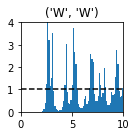

In [7]:
bar_width = histograms[1][1] - histograms[1][0]
pairs = chemical_system.interactions_map[2]
fig, ax = plt.subplots(1, len(pairs), figsize=(len(pairs)*2, 2))
if not isinstance(ax, (list, np.ndarray)):
    ax = [ax]
for i, pair in enumerate(pairs):
    ax[i].bar(histograms[1][:-1],
              histograms[0][pair],
              width=bar_width)
    ax[i].set_title(pair)
    ax[i].plot([0, 10], [1, 1], linestyle='--', color='k')
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 4)
fig.tight_layout()


# Initialize representation, regularizer, and model


In [8]:
bspline_config = BSplineConfig(chemical_system,
                               r_min_map=r_min_map,
                               r_max_map=r_max_map,
                               resolution_map=resolution_map)

representation = BasisProcessor2B(chemical_system,
                                  bspline_config)

regularizer = bspline_config.get_regularization_matrix(
    **regularization_params)
fixed = bspline_config.get_fixed_tuples(values=0,
                                        one_body=False,
                                        upper_bounds=True,
                                        lower_bounds=False)

model = WeightedLinearModel(regularizer=regularizer,
                            fixed_tuples=fixed)

client = ProcessPoolExecutor(max_workers=n_jobs)

# Compute energy and force features using B-spline basis

In [9]:
n_batches = 16  # added granularity for more progress bar updates (optional).
df_features = representation.evaluate_parallel(df_data,
                                               data_coordinator,
                                               client,
                                               n_jobs=n_jobs * n_batches)

100%|██████████| 128/128 [03:41<00:00,  1.73s/it]


In [10]:
df_features.tail()

y  n_W  ij_0  ij_1  ij_2  ij_3      ij_4      ij_5  \
dft_9692 fz_130 -0.349308  0.0  -0.0  -0.0  -0.0  -0.0 -0.731638  0.254634   
         fz_131  0.646192  0.0  -0.0  -0.0  -0.0  -0.0  1.338005 -1.887305   
         fz_132 -1.066545  0.0  -0.0  -0.0  -0.0  -0.0 -0.967187  3.125920   
         fz_133 -0.292102  0.0  -0.0  -0.0  -0.0  -0.0  0.036952 -0.725176   
         fz_134  0.034134  0.0  -0.0  -0.0  -0.0  -0.0 -0.150155  0.699390   

                     ij_6      ij_7  ...      ij_18     ij_19     ij_20  \
dft_9692 fz_130  2.235403 -1.658641  ...  -2.876218 -4.614733 -0.144898   
         fz_131 -2.046937  7.370498  ...  12.229312  6.062230 -0.000000   
         fz_132 -3.120550 -4.939810  ...  -0.800037 -5.154843 -8.518168   
         fz_133  1.554497 -2.723459  ...  13.482874 -6.896420 -2.600800   
         fz_134 -2.843854  3.818630  ...  -7.151680 -0.095159  2.358159   

                     ij_21      ij_22      ij_23      ij_24      ij_25  \
dft_9692 fz_130  -7.735684  -8.188476  32.821889   3.515273 -20.063360   
         fz_131   7.109473  18.085836 -20.974637 -35.492463  26.062205   
         fz_132 -10.845399   7.725257  -3.355608  19.322530   9.590749   
         fz_133  -9.357365  -7.500500  32.415906 -27.554759  10.292425   
         fz_134  -8.780113   4.140042   9.197823  16.211898  -4.778954   

                     ij_26      ij_27  
dft_9692 fz_130 -17.206056  17.001312  
         fz_131  -8.374839  13.584425  
         fz_132   8.948012 -25.013561  
         fz_133  50.156311 -48.320855  
         fz_134  -4.877550 -10.847418  

[5 rows x 30 columns]

# Fit with 20% of the data, using preset training set
### Weighing energies and forces with kappa = 0.9

In [11]:
kappa = 0.9  # energy-force weighting parameter between 0 and 1.

training_keys = np.take(df_data.index, training_indices)
testing_indices = np.setdiff1d(np.arange(len(df_data), dtype=int), training_indices)
testing_keys = np.take(df_data.index, testing_indices)

df_train = df_features.loc[training_keys]
df_test = df_features.loc[testing_keys]
x, y, w = representation.get_training_tuples(df_train,
                                             kappa,
                                             data_coordinator)

In [12]:
model.fit(x, y, weights=w)

# Evaluate Energy and Forces with model

In [13]:
# Evaluate energy
x_test, y_test, w_cond = representation.get_training_tuples(df_test,
                                                            0,
                                                            data_coordinator)
# slice entries corresponding to energies per atom
s_e = df_data.loc[testing_keys][data_coordinator.size_key]
x_e = np.divide(x_test[w_cond == 0].T, s_e.values).T
y_e = y_test[w_cond == 0] / s_e.values
# slice entries corresponding to forces
x_f = x_test[w_cond > 0]
y_f = y_test[w_cond > 0]
# predict with solution
p_e = model.predict(x_e)  # energy per atom
p_f = model.predict(x_f)

# Compute root-mean-square error

In [14]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print("Energy RMSE:", rmse_e, "eV/atom")
print("Forces RMSE:", rmse_f, "eV/angstrom")

Energy RMSE: 0.0252759323919348 eV/atom
Forces RMSE: 0.3063493197592134 eV/angstrom


# Arrange solution into pair-interaction potentials

In [15]:
split_indices = np.cumsum(bspline_config.partition_sizes)[:-1]
solutions_list = np.array_split(model.coefficients,
                                split_indices)
solutions = {element: value for element, value
             in zip(chemical_system.element_list, solutions_list[0])}
for i, pair in enumerate(chemical_system.interactions_map[2]):
    solutions[pair] = solutions_list[i + 1]

In [16]:
for key, value in solutions.items():
    if isinstance(value, (float, np.floating)):
        print("{0}: {1:.6f}".format(key, value))
    else:
        print("{}: vector".format(key), value.shape)

W: -7.507329
('W', 'W'): vector (28,)


# Plot results


<ipython-input-17-ddf32d05ffd1>:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


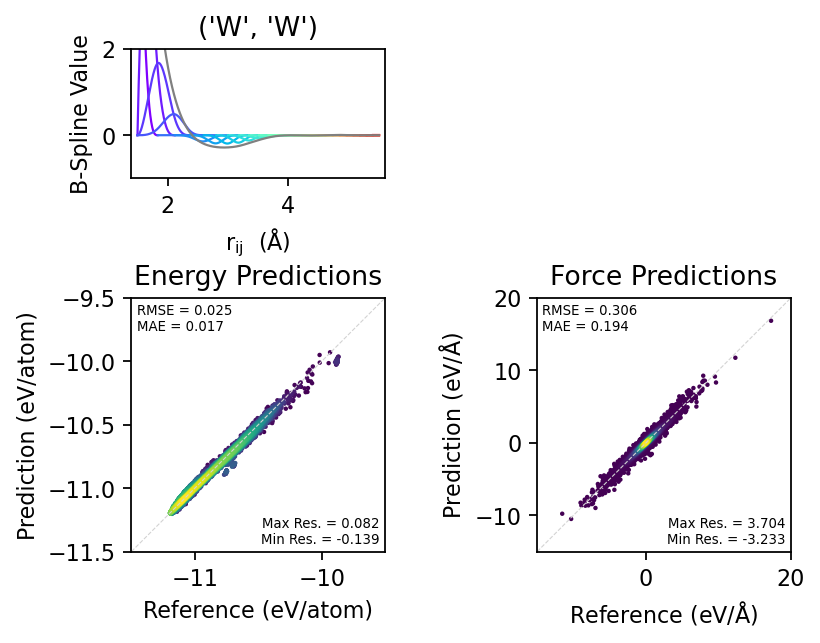

In [17]:
y_min = -1
y_max = 2
ENERGY_UNITS = "eV/atom"
FORCE_UNITS = "eV/$\mathrm{\AA}$"

fig = plt.figure(figsize=(7.48, 4), dpi=160, facecolor='white')
gs = fig.add_gridspec(ncols=3, nrows=2,
                      width_ratios=[1, 1, 1],
                      height_ratios=[0.5, 1])

for i, pair in enumerate(chemical_system.interactions_map[2]):
    ax = fig.add_subplot(gs[0, i])
    r_min = r_min_map[pair]
    r_max = r_max_map[pair]
    knot_sequence = representation.knots_map[pair]
    coefficients = solutions[pair]
    plotting.visualize_splines(coefficients,
                               knot_sequence,
                               ax=ax,
                               s_min=y_min,
                               s_max=y_max,
                               linewidth=1)
    ax.set_ylabel('B-Spline Value')
    ax.set_xlabel('$\mathrm{r_{ij}~~(\AA)}$')
    ax.set_title(pair)
ax2 = fig.add_subplot(gs[1, 0])
plotting.density_scatter(y_e, p_e, ax=ax2, units=ENERGY_UNITS, text_size=6, label_size=10)
ax2.set_xlabel('Reference ({})'.format(ENERGY_UNITS))
ax2.set_ylabel('Prediction ({})'.format(ENERGY_UNITS))

ax3 = fig.add_subplot(gs[1, 1])
plotting.density_scatter(y_f, p_f, ax=ax3, units=FORCE_UNITS,
                         text_size=6, label_size=10)
ax3.set_xlabel('Reference ({})'.format(FORCE_UNITS))
ax3.set_ylabel('Prediction ({})'.format(FORCE_UNITS))

ax2.set_title('Energy Predictions')
ax3.set_title('Force Predictions')
fig.subplots_adjust(left=0.1, right=0.99,
                    bottom=0.15, top=0.94,
                    wspace=0.6, hspace=0.6)
fig.show()


# Export tabulated potentials

In [18]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
print(combined_text)
table_name = os.path.join(example_directory, "table_test", "W.table")
with open(table_name, "w") as f:
    f.write(combined_text)

# DATE: 01/11/2021  UNITS: metal  CONTRIBUTOR: 
# Ultra-Fast Force Field for W-W

UF_W-W
N 26 RSQ 1.5000000000 5.5000000000

1 1.5000000000 9.2049010504 17.4365550186
2 1.8357559751 3.3370716648 13.7356006432
3 2.1189620100 0.8722029938 4.9835628189
4 2.3685438565 0.0643865692 1.8646781601
5 2.5942243542 -0.1956743964 0.6292971007
6 2.8017851452 -0.2734531457 0.1725434718
7 2.9949958264 -0.2821951814 -0.0699065226
8 3.1764760349 -0.2493106496 -0.3070382090
9 3.3481338086 -0.1812716972 -0.4422355359
10 3.5114099732 -0.1105469827 -0.4127097225
11 3.6674241642 -0.0529599429 -0.3123326373
12 3.8170669368 -0.0170400202 -0.1625581092
13 3.9610604641 -0.0031042221 -0.0447698062
14 4.1000000000 -0.0013410965 0.0145678581
15 4.2343830719 -0.0047700919 0.0257142270
16 4.3646305686 -0.0065080885 -0.0011684232
17 4.4911023146 -0.0046066833 -0.0265946059
18 4.6141087980 -0.0003253480 -0.0422267299
19 4.7339201514 0.0044949497 -0.0297852038
20 4.8507731343 0.0057080806 0.0099919828
21 4.9648766349 0